# Functional Specialization metrics

### Imports

In [1]:
import torch.nn as nn
import torch
import numpy as np

# from tqdm import tqdm, trange
from tqdm.notebook import tqdm as tqdm_n
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
from community.data.datasets.datasets import get_datasets_alphabet
from community.data.process import temporal_data
from community.common.init import init_community, init_optimizers
from community.utils.plotting import plot_grid
from community.common.training import train_community
from community.data.tasks import get_task_target


In [6]:
import warnings

# warnings.filterwarnings('ignore')


In [7]:
%load_ext autoreload
#%aimport community.funcspec.masks
%autoreload 2



# Datasets

In [8]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 256
n_classes = 6
(
    multi_loaders,
    double_loaders_dig,
    double_loaders_letters,
    single_loaders,
    letters,
) = get_datasets_alphabet(
    "../../data",
    batch_size,
    use_cuda,
    fix_asym=True,
    n_classes=n_classes,
    split_classes=True,
)


In [14]:
loaders = double_loaders_letters


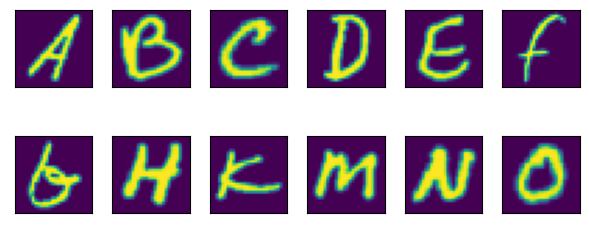

In [15]:
class_split = [d.truncate_values for d in loaders[0].dataset.datasets]
idxs = [
    [(d.targets == c).float().argmax() for c in range(n_classes)]
    for d in loaders[0].dataset.datasets
]
datas = [[d[i][0] for i in idx] for d, idx in zip(loaders[0].dataset.datasets, idxs)]
plot_grid(datas, figsize=(n_classes, 3))


In [16]:
get_all_targets = lambda: torch.cat([t for _, t in loaders[1]])
all_targets = get_all_targets()
uniques, counts = all_targets.unique(dim=0, return_counts=True)
uniques, counts, counts.shape, all_targets.shape


(tensor([[0, 2],
         [0, 3],
         [0, 4],
         [0, 5],
         [1, 0],
         [1, 3],
         [1, 4],
         [1, 5],
         [2, 0],
         [2, 1],
         [2, 4],
         [2, 5],
         [3, 0],
         [3, 1],
         [3, 2],
         [3, 5],
         [4, 0],
         [4, 1],
         [4, 2],
         [4, 3],
         [5, 1],
         [5, 2],
         [5, 3],
         [5, 4]]),
 tensor([443, 464, 488, 426, 452, 469, 433, 463, 486, 450, 466, 440, 466, 452,
         450, 486, 463, 465, 453, 458, 455, 460, 453, 467]),
 torch.Size([24]),
 torch.Size([11008, 2]))

In [20]:
task_t = get_task_target(all_targets, 'parity-digits', n_classes)
task_t.unique(dim=0, return_counts=True), (all_targets.sum(-1) % 2).unique(
    return_counts=True
)


((tensor([0, 1, 2, 3, 4, 5]), tensor([1839, 1792, 1786, 1838, 1877, 1876])),
 (tensor([0, 1]), tensor([5577, 5431])))

### Community Initialization

In [21]:
agents_params_dict = {
    "n_agents": 2,
    "n_in": 784,
    "n_ins": None,
    "n_hid": 50,
    "n_layer": 1,
    "n_out": n_classes,
    "train_in_out": (True, True),
    "use_readout": True,
    "cell_type": str(nn.RNN),
    "use_bottleneck": False,
    "ag_dropout": 0.0,
}

p_con = 5 * 1 / agents_params_dict["n_hid"] ** 2

connections_params_dict = {
    "use_deepR": False,
    "com_dropout": 0.0,
    "binarize": True,
    "sparsity": p_con,
}

community = init_community(agents_params_dict, connections_params_dict, device=device)
print(community.nb_connections)
params = lr, gamma = 5e-4, 0.95
params_dict = {"lr": lr, "gamma": gamma}

deepR_params = l1, gdnoise, lr, gamma, cooling = 1e-5, 1e-3, 5e-4, 0.95, 0.95
deepR_params_dict = {
    "l1": l1,
    "gdnoise": gdnoise,
    "lr": lr,
    "gamma": gamma,
    "cooling": cooling,
}

optimizers, schedulers = init_optimizers(community, params_dict, deepR_params_dict)


TypeError: init_community() got multiple values for argument 'device'

## Training

In [10]:
pre_train = False

pre_training_dict = {
    "n_epochs": 1,
    "task": "none",
    "global_rewire": True,
    "check_gradients": True,
    "reg_factor": 0.0,
    "train_connections": True,
    "decision_params": ("last", "both"),
    "stopping_acc": 0.9,
    "early_stop": True,
    "deepR_params_dict": deepR_params_dict,
}

if pre_train:
    pre_train_out = train_community(
        community,
        *loaders,
        optimizers,
        schedulers=schedulers,
        config=pre_training_dict,
        trials=(True, True),
        device=device,
        use_tqdm=True
    )

training_dict = {
    "n_epochs": 15 + int((1 - p_con) * 10),
    #'n_epochs' : 2
    "task": "parity_digits",
    "global_rewire": False,
    "check_gradients": False,
    "reg_factor": 0.0,
    "train_connections": True,
    "decision_params": ("last", "loss"),
    "stopping_acc": 0.9,
    "early_stop": False,
    "deepR_params_dict": deepR_params_dict,
}

# pyaml.save(training_dict, '../community/common/default_train_dict.yml')

train_out = train_community(
    community,
    *loaders,
    optimizers,
    schedulers=schedulers,
    config=training_dict,
    joint_training=training_dict["decision_params"][-1] == "both"
    and "both" not in training_dict["task"],
    trials=(True, True),
    device=device,
    use_tqdm=True
)

results = train_out
community.best_acc = results["test_accs"].max()


/home/gb21/Code/community-of-agents/community/common/training.py:74: Warning: Empty Theta List
  warnings.warn("Empty Theta List", Warning)


Train Epoch::   0%|          | 0/24 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [14]:
results["test_accs"]


array([0.7018532 , 0.74191497, 0.77334666, 0.78597384, 0.79460392,
       0.80196221, 0.80750363, 0.80732195, 0.81595203, 0.8190407 ,
       0.81676962, 0.82258358, 0.82485465, 0.82458212, 0.82612645,
       0.83030523, 0.83030523, 0.82867006, 0.8300327 , 0.83366642,
       0.83575581, 0.82830669, 0.83230378, 0.83521076])

In [15]:
results["deciding_agents"].mean()


0.4968318495639535

## Analysis


### Connections

In [16]:
sums = []
nonzero_idxs = [c.w_mask.nonzero()[:, 0] for c in community.connections.values()]
for data, target in loaders[1]:
    data = temporal_data(data)
    out, states, conns = community(data.to(device))
    # conns[-1][0].count_nonzero(dim=0)
    # torch.stack([conns[-1][i].count_nonzero(dim=0).max() for i in range(2)])
    # sums.append(torch.tensor([[conns[-1][i][target[:, i] == t].sum() for t in range(4)] for i in range(2)]))
    sums.append(
        torch.stack(
            [
                torch.stack(
                    [
                        conns[-1][i][target[:, 1 - i] == t][:, nonzero_idxs[1 - i]].sum(
                            0
                        )
                        for t in range(n_classes)
                    ]
                )
                for i in range(2)
            ]
        )
    )
sums = torch.stack(sums)
sums.mean(0)


tensor([[[34.1163, 16.3488, 24.5581, 42.5116,  5.6744],
         [ 7.3953, 40.4651,  5.4186, 42.7674, 33.7907],
         [36.9535, 37.0930, 22.3953, 41.7907,  3.6047],
         [ 6.3488, 41.7442,  0.7442, 42.0698, 39.2791],
         [29.1163, 40.2558, 13.8372, 42.3023, 26.6744],
         [ 2.2326, 39.2093,  5.0698, 42.3488, 38.8140]],

        [[40.1860, 19.5349,  7.1163, 43.6512, 22.7907],
         [40.7209,  1.1860,  1.0930, 42.5349, 35.9767],
         [42.2326,  2.2093,  1.2558, 19.4186, 32.5581],
         [34.1395, 33.2093,  1.0233, 40.5349, 38.2326],
         [42.6512,  0.2558,  0.6047, 42.9767,  7.2326],
         [41.2093,  0.5116,  2.0465, 41.4419,  3.8605]]], device='cuda:0',
       grad_fn=<MeanBackward1>)

 ### Decisions

In [11]:
from community.common.decision import get_decision

/tmp/ipykernel_174613/577999320.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = target.eq(torch.tensor(t)).all(axis=1)


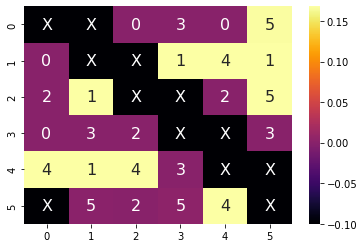

In [13]:
if "all_targets" not in globals():
    all_targets = get_all_targets()

uniques = all_targets.unique(dim=0)
decision_params = training_dict["decision_params"]
decision_means = torch.zeros(len(uniques))
for data, target in loaders[1]:
    data, t_target = temporal_data(data).to(device), get_task_target(target.to(device))
    output, *_ = community(data)
    output, decision_ags = get_decision(output, *decision_params, target=t_target)

    for i, t in enumerate(uniques):
        mask = target.eq(torch.tensor(t)).all(axis=1)
        decision_means[i] += decision_ags[mask].float().cpu().mean() / mask.numel()

digits_in = lambda d1, d2: (torch.tensor([d1, d2]) == uniques).all(1).any()
digits_idx = lambda d1, d2: (torch.tensor([d1, d2]) == uniques).all(1).float().argmax()
decisions = np.zeros((n_classes, n_classes))
targets = np.zeros((n_classes, n_classes), dtype=object)
for d1 in range(n_classes):
    for d2 in range(n_classes):
        if digits_in(d1, d2):
            decisions[d1, d2] = decision_means[digits_idx(d1, d2)]
            targets[d1, d2] = str(
                get_task_target(uniques)[digits_idx(d1, d2)].cpu().data.item()
            )
        else:
            decisions[d1, d2] = -0.1
            targets[d1, d2] = "X"
ax = sns.heatmap(
    decisions, cmap="inferno", annot=targets, annot_kws={"fontsize": 16}, fmt="s"
)
try:
    ax.set_title(f'Overall decision = {results["deciding_agents"].mean():.3f}')
except NameError:
    "continue"
plt.show()


# Metrics

### Correlation 

In [14]:
from community.funcspec.correlation import (
    fixed_information_data,
    get_pearson_metrics,
    get_pearson_metrics_2,
    compute_correlation_metric,
    plot_correlations,
    v_pearsonr,
    get_correlation,
    randperm_no_fixed,
)


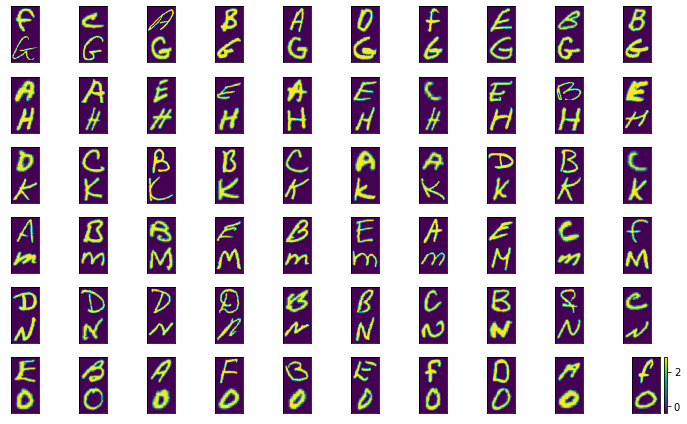

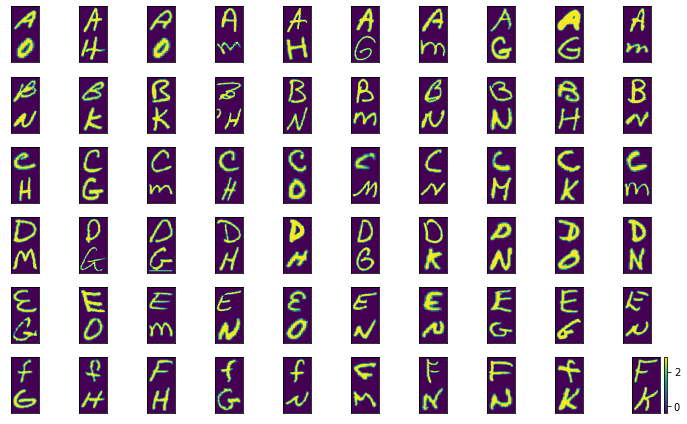

array([[0.70434729, 0.39077743],
       [0.42393642, 0.67234942]])

In [30]:
datas, label = next(iter(loaders[1]))
means = [[] for digit in range(2)]
n = 40
# for (datas, label), i in zip(loaders[1], range(n)) :
datas = temporal_data(datas).to(device)
d = datas.clone()
for target_digit in [1, 0]:

    fixed_data = fixed_information_data(
        datas, label, fixed=target_digit, fixed_mode="label"
    )
    fixed_datas = [
        [d.reshape(1, 56, 28) for d in data[0, :, :10, :].transpose(0, 1).cpu()]
        for data in fixed_data
    ]
    # labels = [[]]
    plot_grid(fixed_datas, figsize=(10, 1 * len(fixed_datas)))

    outs = [community(f) for f in fixed_data]
    states = [o[1] for o in outs]

    states_0 = [s[-1][0][0].cpu().data.numpy() for s in states]
    states_1 = [s[-1][1][0].cpu().data.numpy() for s in states]

    [s.shape for s in states_0]
    perm = lambda s: randperm_no_fixed(s.shape[0])

    corrs_0 = [v_pearsonr(s, s[perm(s)])[0] for s in states_0]
    corrs_1 = [v_pearsonr(s, s[perm(s)])[0] for s in states_1]

    cors = [
        np.array([c.mean() for c in corrs_0]),
        np.array([c.mean() for c in corrs_1]),
    ]
    means[target_digit].append(cors)

means = np.array(means).transpose(0, 2, 1, 3)
means.mean(-1).mean(-1)


In [23]:
datas.shape

torch.Size([2, 2, 256, 784])

In [37]:
means.mean(-1).mean(1)

array([[0.66464027, 0.48611748],
       [0.4424113 , 0.68679885]])

In [27]:
corrs1 = get_pearson_metrics(
    community, loaders, use_tqdm=True, device=device, fixed_mode="label"
)
corrs2 = get_pearson_metrics_2(
    community, loaders, use_tqdm=True, device=device, fixed_mode="label"
)


Correlation Metric Trials:   0%|          | 0/43 [00:00<?, ?it/s]

Correlation Metric Trials:   0%|          | 0/43 [00:00<?, ?it/s]

In [28]:
corrs1.mean(-1).mean(-1), corrs2.mean(-1).mean(-1)

(array([[0.69807959, 0.38284758],
        [0.40250903, 0.65497629]]),
 array([[0.69895636, 0.3838332 ],
        [0.39754821, 0.65366689]]))

In [ ]:
diff = lambda n: (corrs.mean(-1).mean(-1)[n, n] - corrs.mean(-1).mean(-1)[1 - n, n]) / (
    corrs.mean(-1).mean(-1)[n, n] + corrs.mean(-1).mean(-1)[1 - n, n]
)
[diff(n) for n in range(2)]


In [ ]:
from community.common.utils import get_wandb_artifact

community_states, *_ = get_wandb_artifact(name="state_dicts", project="funcspec")


In [ ]:
correlations = {}
for p_con, states in tqdm_n(community_states.items()):
    correlations[p_con] = []
    for state in states[:]:
        community.load_state_dict(state)
        correlations[p_con].append(
            get_pearson_metrics(community, multi_loaders, use_tqdm=False, device=device)
        )
    correlations[p_con] = np.array(correlations[p_con])


In [ ]:
pearson_correlations = {}
pearson_correlations["Pearson_Label"] = correlations


In [ ]:
plot_correlations(pearson_correlations)

### Bottleneck

In [ ]:
from community.funcspec.bottleneck import readout_retrain, compute_bottleneck_metrics


In [ ]:
bottleneck_metric = readout_retrain(
    community,
    loaders,
    device=device,
    use_tqdm=True,
    n_epochs=2,
    n_tests=1,
    train_all_param=False,
)


In [ ]:
bottleneck_metric["accs"][0]


In [ ]:
diff = lambda n: (
    bottleneck_metric["accs"].mean(0)[n, n]
    - bottleneck_metric["accs"].mean(0)[1 - n, n]
) / (
    bottleneck_metric["accs"].mean(0)[n, n]
    + bottleneck_metric["accs"].mean(0)[1 - n, n]
)
[diff(n) for n in range(2)]


### Weight Masks

In [ ]:
from community.funcspec.masks import (
    train_and_get_mask_metric,
    compute_mask_metric,
    Mask_Community,
    get_proportions,
    get_proportions_per_agent,
    train_mask,
    find_optimal_sparsity,
)


In [ ]:
masked_community, test_loss, test_accs, best_state = train_mask(
    community, 0.1, 0, loaders, use_tqdm=True
)


In [ ]:
masks_metric = train_and_get_mask_metric(
    community,
    0.1,
    loaders,
    device=device,
    n_tests=1,
    n_epochs=2,
    use_tqdm=True,
    use_optimal_sparsity=True,
)


In [ ]:
masks_metric["proportions"]


In [ ]:
diff = lambda n: (
    masks_metric["proportions"][0][n, n] - masks_metric["proportions"][0][1 - n, n]
) / (masks_metric["proportions"][0][n, n] + masks_metric["proportions"][0][1 - n, n])
[diff(n) for n in range(2)]


In [ ]:
masks_metric["test_accs"]


In [ ]:
masks_metric["sparsities"].mean(0)


## WandB Loading

In [ ]:
from community.common.wandb_utils import get_wandb_runs, get_wandb_artifact
import wandb, torch, numpy as np

In [ ]:
# runs = get_wandb_runs(run_id=None)
artifacts = get_wandb_artifact(project="funcspec", name="all_results")


In [ ]:
artifacts[0]["Correlation"]


In [ ]:
from community.funcspec.masks import plot_mask_metric, get_metrics_from_saved_masks

In [ ]:
mask_metric = get_metrics_from_saved_masks(mask_metric, sparsities=[0.2])

In [ ]:
plot_mask_metric(mask_metric)

# New Polygon Task

In [ ]:
from math import radians, pi, cos, sin
import numpy as np


def draw_polygon(sides, x0, y0, r=1, rotate=0):
    """Draw an n-sided regular polygon.

    Args:
        sides (int): Number of polygon sides.
        x0, y0 (int): Coordinates of center point.
        r (int): Radius.
        color (int): RGB565 color value.
        rotate (Optional float): Rotation in degrees relative to origin.
    Note:
        The center point is the center of the x0,y0 pixel.
        Since pixels are not divisible, the radius is integer rounded
        up to complete on a full pixel.  Therefore diameter = 2 x r + 1.
    """
    coords = []
    theta = pi / 2
    n = sides + 1
    for s in range(n):
        t = 2.0 * pi * s / sides + theta
        coords.append([r * cos(t) + x0, r * sin(t) + y0])

    # Cast to python float first to fix rounding errors
    # self.draw_lines(coords, color=color)
    return np.array(coords)


In [ ]:
poly

In [ ]:
poly = draw_polygon(15, 0, 0)
fig = plt.figure(figsize=(0.7, 0.7))
plt.plot(poly[:, 0], poly[:, 1], linewidth=0.1)
plt.axis("off")
plt.tight_layout(pad=0.0)
plt.savefig("poly.png")
# rs = Resize((28, 28), interpolation=InterpolationMode.HAMMING)
poly_tensor = TF.to_tensor(Image.open("poly.png"))[:1]
print(poly_tensor.shape)
pad = (poly_tensor.shape[1] - 28) // 2
digits = TF.normalize(
    TF.pad(next(iter(single_loaders[0]))[0][0], [pad, pad], fill=0), 1, 1
)
print(digits.shape)
poly_tensor = TF.normalize(TF.resize(poly_tensor, digits.shape[1]), 1, 1)


In [ ]:
final = (1 - poly_tensor.data.numpy() + digits.data.numpy())[0]
plt.imshow(final)

In [ ]:
digits.max()

In [ ]:
from PIL import Image
import torchvision.transforms.functional as TF
from torchvision.transforms import ToTensor, Resize, InterpolationMode, Pad

In [ ]:
poly = pat.RegularPolygon((0, 0), 10)
plt.plot(poly)

In [ ]:
plt.scatter(poly.get_path()

# Others


In [ ]:
from community.common.wandb_utils import get_wandb_runs


In [ ]:
metrics = torch.load(
    "/home/gb21/Code/ANNs/community-of-agents/wandb/latest-run/files/single/metrics/metric_results"
)
training = torch.load(
    "/home/gb21/Code/ANNs/community-of-agents/wandb/latest-run/files/single/training/training_results"
)


In [ ]:
community.load_state_dict(training[0.1][True]["best_state"])


In [ ]:
corrs = get_pearson_metrics(
    community, multi_loaders, device=device, use_tqdm=True, n_tests=128
)


In [ ]:
cor = corrs.mean(-1).mean(-1)
cor

In [ ]:
cor = metrics["Correlation"][0.1]
bot = metrics["Bottleneck"][0.1]
mask = metrics["Masks"][0.1]


In [ ]:
bottleneck = readout_retrain(
    community, multi_loaders, n_epochs=1, n_tests=1, use_tqdm=True, device=device
)


In [ ]:
bot = bottleneck["accs"].mean(0).max(-1)


In [ ]:
i = 1
(cor[i, i] - cor[1 - i, i]) / (cor[0, i] + cor[1, i])


In [ ]:
ag_metric = lambda metric, ag: (metric[ag, ag], metric[1 - ag, ag])
diff_metric = lambda metric, ag: (
    (ag_metric(metric, ag)[0] - ag_metric(metric, ag)[1])
    / (ag_metric(metric, ag)[0] + ag_metric(metric, ag)[1])
)


In [ ]:
mask